#### Display Single Cell Data
Look at embedding space created by scCVC on the single cell level.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/romi/projects/cvc


In [3]:
import os, sys
import collections
import importlib
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import anndata as ad
import scanpy as sc

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)

from cvc import model_utils
from cvc import plot_utils
from cvc import utils
from single_cell_research import cvc_sequencing as cs
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

#### Load data

In [4]:
# load data db
data_dir = DATA_DIR + "10x_nsclc_tra_trb_df.csv"
orig_data = pd.read_csv(data_dir, engine="pyarrow")

In [5]:
orig_data

,,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,TRBJ1-1,TRBC1,True,True,CASSSQGGTEAFF,TGTGCCAGCAGCTCCCAGGGTGGGACTGAAGCTTTCTTT,7070,5,clonotype194,clonotype194_consensus_2
1,1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,TRAJ52,TRAC,True,True,CAVAPAGGTSYGKLTF,TGTGCTGTGGCCCCTGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,4152,3,clonotype194,clonotype194_consensus_1
2,2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,TRBJ2-7,TRBC2,True,True,CASSLYGRSYEQYF,TGTGCCAGCAGTTTATACGGGCGGTCCTACGAGCAGTACTTC,17459,18,clonotype15,clonotype15_consensus_2
3,3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,TRAJ28,TRAC,True,True,CAENDSGAGSYQLTF,TGTGCAGAGAATGACTCTGGGGCTGGGAGTTACCAACTCACTTTC,5129,4,clonotype15,clonotype15_consensus_1
4,4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,TRAC,True,False,CGADQGWQQP*ADL,TGTGGAGCAGACCAAGGCTGGCAACAACCGTAAGCTGATTTG,2718,2,clonotype15,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,TRAJ5,TRAC,True,True,CAMRGRDTGRRALTF,TGTGCAATGAGAGGTCGGGACACGGGCAGGAGAGCACTTACTTTT,17250,18,clonotype1130,clonotype1130_consensus_2
3639,5093,TCATTACCACCAGCAC-1_contig_1,TGGGGAGAGCCCAGCACCTCACCCAGAGGACCCCAGTCAGAGGCCC...,TCATTACCACCAGCAC-1,True,True,536,TRB,TRBV4-3,TRBD2,TRBJ2-2,TRBC2,True,True,CASSPTSGFAGELFF,TGCGCCAGCAGTCCCACTAGCGGGTTTGCCGGGGAGCTGTTTTTT,11698,11,clonotype5,clonotype5_consensus_2
3640,5094,TCATTACCACCAGCAC-1_contig_4,ATTGATCCTTTTCTTATATGGGGGTTGAATACACAAGTCAACTTCT...,TCATTACCACCAGCAC-1,True,True,543,TRA,TRAV10,None,TRAJ6,TRAC,True,True,CVVSESGGSYIPTF,TGTGTGGTGAGCGAATCAGGAGGAAGCTACATACCTACATTT,3067,5,clonotype5,clonotype5_consensus_1
3641,5097,TGGTTAGAGAGGGCTT-1_contig_1,GGGGAGTGGAAACCACAGCCTAGTCCTCTCACCACTGCAGACCAGA...,TGGTTAGAGAGGGCTT-1,True,True,710,TRB,TRBV3-1,None,TRBJ2-5,TRBC2,True,True,CASSQERIQETQYF,TGTGCCAGCAGCCAAGAAAGGATTCAGGAGACCCAGTACTTC,8758,10,clonotype1424,clonotype1424_consensus_1


In [6]:
orig_data_edit = orig_data
orig_data_edit.rename(columns={'barcode': 'barcode_unique'}, inplace=True)

In [7]:
orig_data_edit

,,contig_id,sequence,barcode_unique,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,TRBJ1-1,TRBC1,True,True,CASSSQGGTEAFF,TGTGCCAGCAGCTCCCAGGGTGGGACTGAAGCTTTCTTT,7070,5,clonotype194,clonotype194_consensus_2
1,1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,TRAJ52,TRAC,True,True,CAVAPAGGTSYGKLTF,TGTGCTGTGGCCCCTGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,4152,3,clonotype194,clonotype194_consensus_1
2,2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,TRBJ2-7,TRBC2,True,True,CASSLYGRSYEQYF,TGTGCCAGCAGTTTATACGGGCGGTCCTACGAGCAGTACTTC,17459,18,clonotype15,clonotype15_consensus_2
3,3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,TRAJ28,TRAC,True,True,CAENDSGAGSYQLTF,TGTGCAGAGAATGACTCTGGGGCTGGGAGTTACCAACTCACTTTC,5129,4,clonotype15,clonotype15_consensus_1
4,4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,TRAC,True,False,CGADQGWQQP*ADL,TGTGGAGCAGACCAAGGCTGGCAACAACCGTAAGCTGATTTG,2718,2,clonotype15,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,TRAJ5,TRAC,True,True,CAMRGRDTGRRALTF,TGTGCAATGAGAGGTCGGGACACGGGCAGGAGAGCACTTACTTTT,17250,18,clonotype1130,clonotype1130_consensus_2
3639,5093,TCATTACCACCAGCAC-1_contig_1,TGGGGAGAGCCCAGCACCTCACCCAGAGGACCCCAGTCAGAGGCCC...,TCATTACCACCAGCAC-1,True,True,536,TRB,TRBV4-3,TRBD2,TRBJ2-2,TRBC2,True,True,CASSPTSGFAGELFF,TGCGCCAGCAGTCCCACTAGCGGGTTTGCCGGGGAGCTGTTTTTT,11698,11,clonotype5,clonotype5_consensus_2
3640,5094,TCATTACCACCAGCAC-1_contig_4,ATTGATCCTTTTCTTATATGGGGGTTGAATACACAAGTCAACTTCT...,TCATTACCACCAGCAC-1,True,True,543,TRA,TRAV10,None,TRAJ6,TRAC,True,True,CVVSESGGSYIPTF,TGTGTGGTGAGCGAATCAGGAGGAAGCTACATACCTACATTT,3067,5,clonotype5,clonotype5_consensus_1
3641,5097,TGGTTAGAGAGGGCTT-1_contig_1,GGGGAGTGGAAACCACAGCCTAGTCCTCTCACCACTGCAGACCAGA...,TGGTTAGAGAGGGCTT-1,True,True,710,TRB,TRBV3-1,None,TRBJ2-5,TRBC2,True,True,CASSQERIQETQYF,TGTGCCAGCAGCCAAGAAAGGATTCAGGAGACCCAGTACTTC,8758,10,clonotype1424,clonotype1424_consensus_1


In [8]:
# join between a single cell's CDR3 sequences (the function can be used to concatenate any column, by single cell id's)
real_seqs_concat = cs.create_tcr_seqs(orig_data_edit)

100%|███████████████████████████████████| 3642/3642 [00:00<00:00, 781683.31it/s]


#### Create and Display embeddings

In [15]:
embed_data = pd.read_csv("./single_cell_research/10x_nsclc/concatenated_seqs_df.csv")
embed_data

,Unnamed: 0,Sequences,v_gene,j_gene,MAIT_cell
0,0,CASSSQGGTEAFF|CAVAPAGGTSYGKLTF,TRBV11-2|TRAV21,TRBJ1-1|TRAJ52,non-MAIT_cell
1,1,CASSLYGRSYEQYF|CAENDSGAGSYQLTF|CGADQGWQQP*ADL,TRBV27|TRAV13-2|TRAV34,TRBJ2-7|TRAJ28|TRAJ38,non-MAIT_cell
2,2,CASSLDRGEQYF|CAVNGEGTYKYIF,TRBV6-6|TRAV8-1,TRBJ2-7|TRAJ40,non-MAIT_cell
3,3,CIVRSSNFGNEKLTF,TRAV26-1,TRAJ48,non-MAIT_cell
4,4,CAGKEEAYEQYF|CAEESGGYNKLIF|CAVRENAGKSTF,TRBV2|TRAV5|TRAV3,TRBJ2-7|TRAJ4|TRAJ27,non-MAIT_cell
...,...,...,...,...,...
1803,1803,CAMSDANDMRF,TRAV12-3,TRAJ43,non-MAIT_cell
1804,1804,CASLATLYNEQFF|CAVERGGATNKLIF,TRBV7-2|TRAV41,TRBJ2-1|TRAJ32,non-MAIT_cell
1805,1805,CASAQGLGTNEKLFF|CAMRGRDTGRRALTF,TRBV19|TRAV14DV4,TRBJ1-4|TRAJ5,non-MAIT_cell
1806,1806,CASSPTSGFAGELFF|CVVSESGGSYIPTF,TRBV4-3|TRAV10,TRBJ2-2|TRAJ6,non-MAIT_cell


In [22]:
df_for_embedding = embed_data

from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(SC_TRANSFORMER, DEVICE, df_for_embedding, batch_size=128, method="mean", layers=[-1], pbar=True, max_len=120)
embed_wrap.embeddings.shape

Some weights of the model checkpoint at /home/romi/projects/cvc/output_dir_singlecell_v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/15 [00:00<?, ?it/s]

(1808, 768)

In [23]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


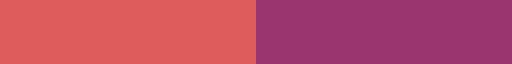

In [24]:
# Create colormap of 16 shades of blues
color_map = ListedColormap(sns.color_palette("flare", 2))
# color_map = ListedColormap(sns.color_palette("pastel", 52))
color_map

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


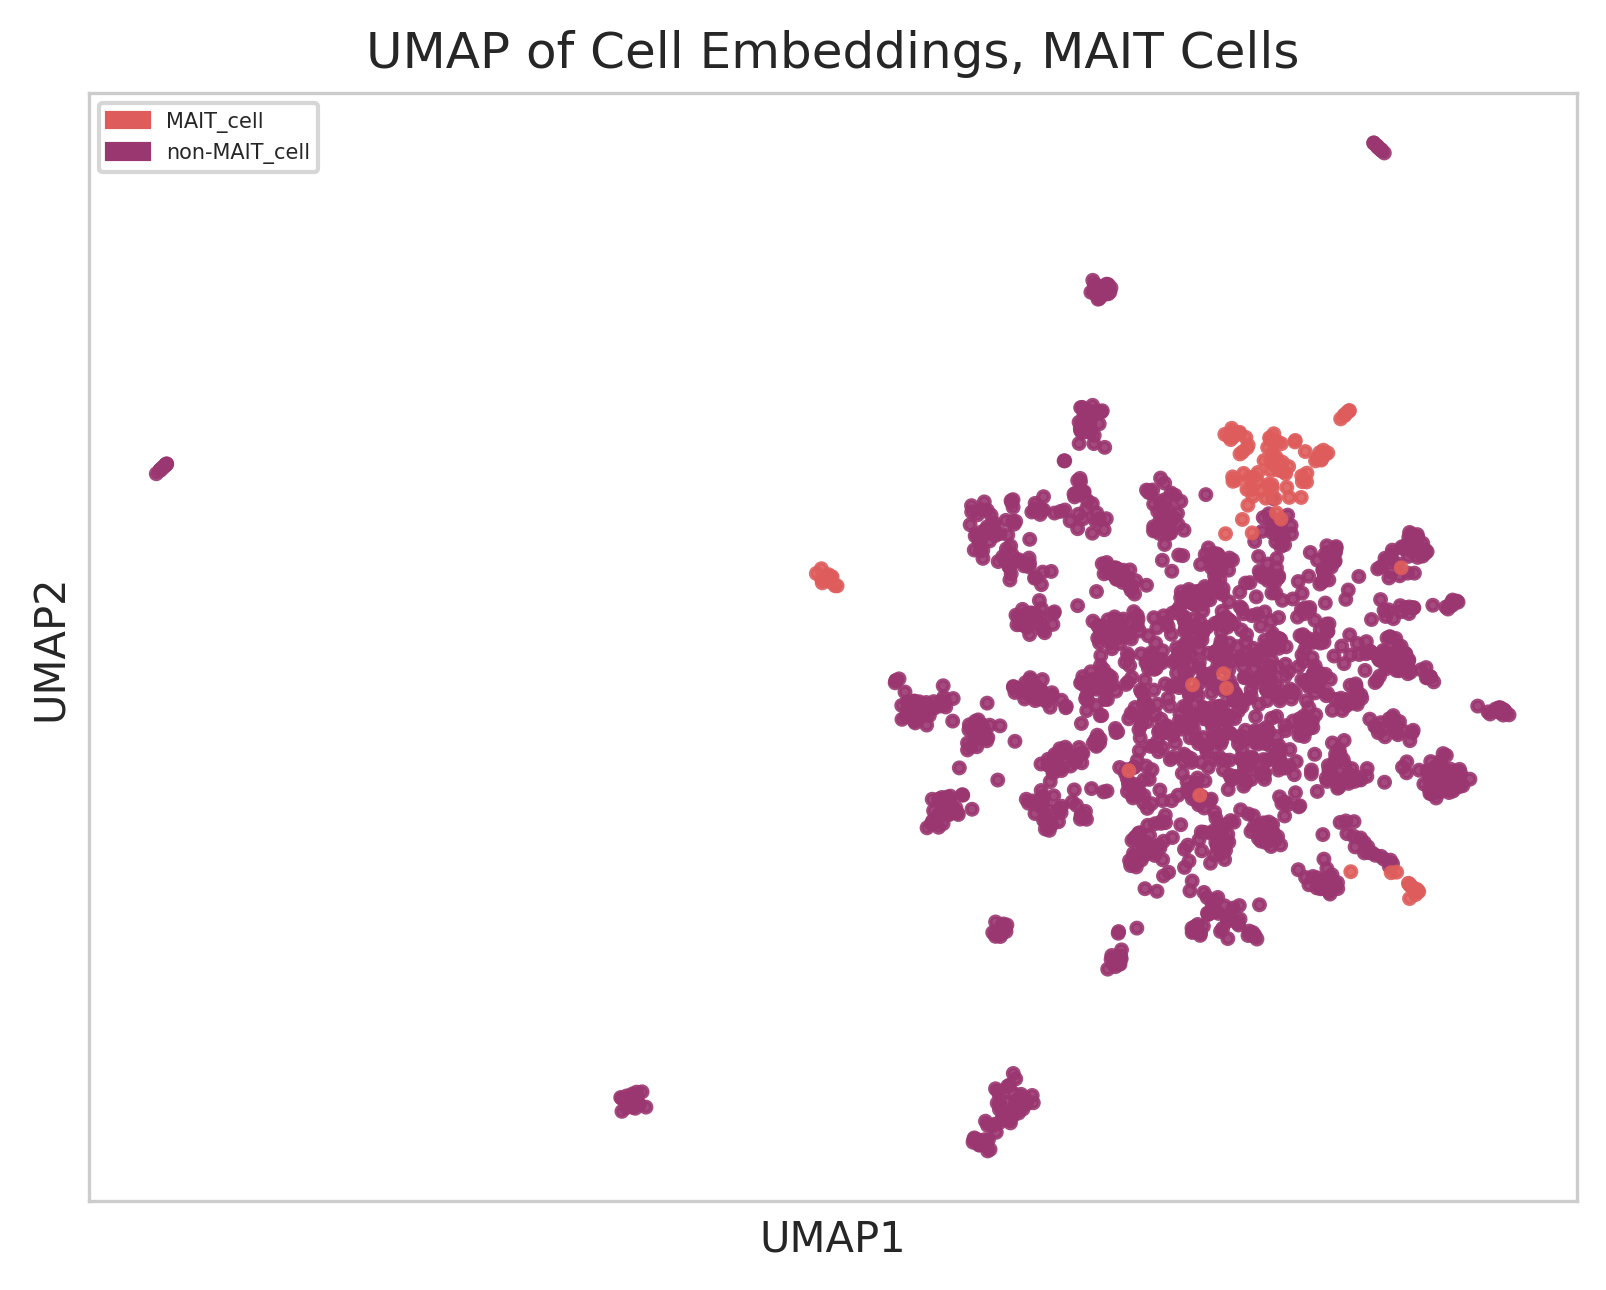

In [26]:
# Plot embeddings
importlib.reload(plot_utils)
embed_wrap.sequences_df.sort_values(by='MAIT_cell', inplace=True,  ascending=False)
embed_wrap.plot_embedding(
    color_embed='MAIT_cell',
    color_map=color_map,
    title="UMAP of Cell Embeddings, MAIT Cells",
    legend_size=5,
    plot_pdf_path=os.path.join(PLOT_DIR, "umap_chain_single_cell.pdf"),
)